In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_score, recall_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers.legacy import Adam
from imblearn.under_sampling import NearMiss
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve

In [2]:
original_df = pd.read_csv('pairs_with_embeddings.csv')

In [63]:
df=original_df

In [64]:
need_emb_cols = [f'need_emb_{i}' for i in range(3072)]
res_emb_cols = [f'res_emb_{i}' for i in range(3072)]

# Convert to NumPy arrays
need_embs = df[need_emb_cols].to_numpy()
res_embs = df[res_emb_cols].to_numpy()

# Compute cosine similarity row-wise
cos_sim = np.einsum('ij,ij->i', need_embs, res_embs) / (
    np.linalg.norm(need_embs, axis=1) * np.linalg.norm(res_embs, axis=1) + 1e-9
)

df['cosine_similarity'] = cos_sim

In [65]:
# Create richer features
df['l2_distance'] = np.linalg.norm(need_embs - res_embs, axis=1)
df['dot_product'] = np.einsum('ij,ij->i', need_embs, res_embs)

# Optional: elementwise interaction features
interaction = need_embs * res_embs
interaction_mean = interaction.mean(axis=1)
df['interaction_mean'] = interaction_mean

In [66]:
clusters = pd.read_csv('clusters.csv')
clusters.head()

,academic_resource_id,name
0,391,Cluster 1
1,321,Sociología_Prácticas
2,640,Cluster 2
3,225,Cluster 3
4,253,Cluster 4


In [67]:
merged = df.merge(clusters, on="academic_resource_id", how="left")
merged.head()

,need_id,need_name,need_description,need_expiration_date,need_created_at,need_internship,offer_name,offer_description,offer_semester,offer_company_year,...,res_emb_3067,res_emb_3068,res_emb_3069,res_emb_3070,res_emb_3071,cosine_similarity,l2_distance,dot_product,interaction_mean,name
0,1456,Investigación sobre los factores que inciden e...,De acuerdo a la temáticas sociales y en especi...,2019-08-04,2019-02-04 14:56:21.388586,True,Pasantía de College 1-2019,"Pasantía cocurricular de al menos 160 horas, d...",0.0,2019,...,0.048212,0.003851,-0.013416,-0.028706,-0.004475,0.411339,1.085045,0.411339,0.000134,College CCNN_Pasantías
1,5168,Apoyo y elaboración de plan de marketing para ...,La Fábrica de Renca es una entidad privada sin...,2024-03-20,2023-09-20 20:05:59.124840,True,Práctica Profesional 2-2023,Práctica profesional obligatoria de 320 horas ...,1.0,2023,...,0.039514,-0.000184,-0.006662,-0.018958,-0.012061,0.486173,1.013733,0.486173,0.000158,Comercial_Prácticas
2,5152,Taller de Intervención para Programa de Calle ...,El curso taller de intervención tiene como pro...,2024-03-06,2023-09-06 19:51:21.818464,True,Taller de Intervención 2-2023,Taller de intervención dirigido a estudiantes ...,1.0,2023,...,0.049481,-0.002994,-0.004206,-0.003688,0.003104,0.782764,0.659146,0.782764,0.000255,Trabajo Social_Práctica Inicial
3,3993,Diagnóstico de la población migrante en Renca ...,Desde el departamento de inclusión de la munic...,2022-09-22,2022-03-22 13:54:44.014323,True,Pasantía Verano-2021,"Pasantía cocurricular de al menos 160 horas, d...",2.0,2021,...,0.045297,-0.006526,-0.019708,-0.012770,-0.005960,0.520189,0.979603,0.520189,0.000169,Sociología_Prácticas
4,1907,Práctica Inicial Trabajo Social (II) - Unidad ...,Dentro de los objetivos de la Unidad Técnica d...,2020-02-19,2019-08-19 14:00:49.570249,True,Práctica Inicial II 2-2019,Segunda parte del taller de intervención dirig...,1.0,2019,...,0.046884,-0.001429,-0.001713,-0.005516,0.009988,0.396248,1.098865,0.396248,0.000129,Trabajo Social_Práctica Inicial


In [68]:
df = merged
df = df.drop(columns=['academic_resource_description','need_id','need_name','need_description','need_expiration_date','need_created_at','offer_description','offer_name','offer_semester','offer_company_year','offer_expiration_date','offer_academic_resource_id','offer_created_at','academic_resource_name'])


In [69]:
df["need_internship"] = df["need_internship"].astype(int)

In [70]:
df[df.isnull().any(axis=1)].shape

(0, 6154)

In [71]:
df = df.dropna()
df.head()

,need_internship,academic_resource_id,academic_resource_level,academic_resource_type_id,has_match,need_emb_0,need_emb_1,need_emb_2,need_emb_3,need_emb_4,...,res_emb_3067,res_emb_3068,res_emb_3069,res_emb_3070,res_emb_3071,cosine_similarity,l2_distance,dot_product,interaction_mean,name
0,1,250,1,24,1,-0.011038,0.009111,-0.007517,-0.016986,0.014604,...,0.048212,0.003851,-0.013416,-0.028706,-0.004475,0.411339,1.085045,0.411339,0.000134,College CCNN_Pasantías
1,1,205,2,21,1,-0.008638,0.036582,-0.013364,-0.018138,0.011307,...,0.039514,-0.000184,-0.006662,-0.018958,-0.012061,0.486173,1.013733,0.486173,0.000158,Comercial_Prácticas
2,1,582,1,21,1,0.010936,0.034407,-0.001854,0.008706,0.020503,...,0.049481,-0.002994,-0.004206,-0.003688,0.003104,0.782764,0.659146,0.782764,0.000255,Trabajo Social_Práctica Inicial
3,1,330,2,24,1,-0.007967,0.022626,-0.013080,-0.032534,0.038485,...,0.045297,-0.006526,-0.019708,-0.012770,-0.005960,0.520189,0.979603,0.520189,0.000169,Sociología_Prácticas
4,1,286,1,21,1,0.002075,-0.005712,-0.003436,-0.047204,0.015465,...,0.046884,-0.001429,-0.001713,-0.005516,0.009988,0.396248,1.098865,0.396248,0.000129,Trabajo Social_Práctica Inicial


In [72]:
# dummy categories columns
categorical_cols = ['academic_resource_id','academic_resource_level','academic_resource_type_id','name']
df_dummies = pd.get_dummies(df, columns=categorical_cols)
df_dummies
df = df_dummies

In [73]:
X = df.drop(columns=['has_match'])
y = df['has_match']

In [74]:
# 6. Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [75]:
# 5. Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Use the same scaler to transform the validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [76]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Shape of original training data:", X_train_scaled.shape)
print("Shape of resampled training data:", X_train_resampled.shape)
y_train = y_train_resampled
X_train_scaled = X_train_resampled

Shape of original training data: (68108, 6664)
Shape of resampled training data: (129362, 6664)


In [77]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weight_dict

{0: 1.0, 1: 1.0}

In [78]:
callbacks = [
    EarlyStopping(monitor="val_pr_auc", mode="max", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_pr_auc", mode="max", factor=0.5, patience=2, verbose=1),
]


In [79]:
# 7. Build the model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # clasificación binaria
])

In [80]:
pr_auc = AUC(curve="PR", name="pr_auc")
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[Precision(name="precision"), Recall(name="recall"), AUC(name="auc"), pr_auc],
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               853120    
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_7 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 64)               

In [81]:
# 8. Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    # class_weight=class_weight_dict
)

Epoch 1/100
4043/4043 [==============================] - 10s 2ms/step - loss: 0.3620 - precision: 0.8280 - recall: 0.8605 - auc: 0.9187 - pr_auc: 0.9106 - val_loss: 0.2167 - val_precision: 0.3367 - val_recall: 0.8191 - val_auc: 0.9480 - val_pr_auc: 0.5870 - lr: 1.0000e-04
Epoch 2/100
4043/4043 [==============================] - 9s 2ms/step - loss: 0.1975 - precision: 0.9149 - recall: 0.9382 - auc: 0.9748 - pr_auc: 0.9693 - val_loss: 0.1593 - val_precision: 0.4271 - val_recall: 0.7946 - val_auc: 0.9558 - val_pr_auc: 0.6318 - lr: 1.0000e-04
Epoch 3/100
4043/4043 [==============================] - 9s 2ms/step - loss: 0.1585 - precision: 0.9334 - recall: 0.9519 - auc: 0.9830 - pr_auc: 0.9787 - val_loss: 0.1495 - val_precision: 0.4511 - val_recall: 0.7897 - val_auc: 0.9547 - val_pr_auc: 0.6467 - lr: 1.0000e-04
Epoch 4/100
4043/4043 [==============================] - 9s 2ms/step - loss: 0.1379 - precision: 0.9431 - recall: 0.9591 - auc: 0.9866 - pr_auc: 0.9828 - val_loss: 0.1443 - val_precis

In [82]:
# 9. Evaluate the model
metrics = model.evaluate(X_test_scaled, y_test)
print(metrics)

267/267 [==============================] - 0s 784us/step - loss: 0.1276 - precision: 0.5777 - recall: 0.7644 - auc: 0.9582 - pr_auc: 0.6755      
[0.1276199370622635, 0.5776614546775818, 0.7644341588020325, 0.9581993222236633, 0.6755352020263672]


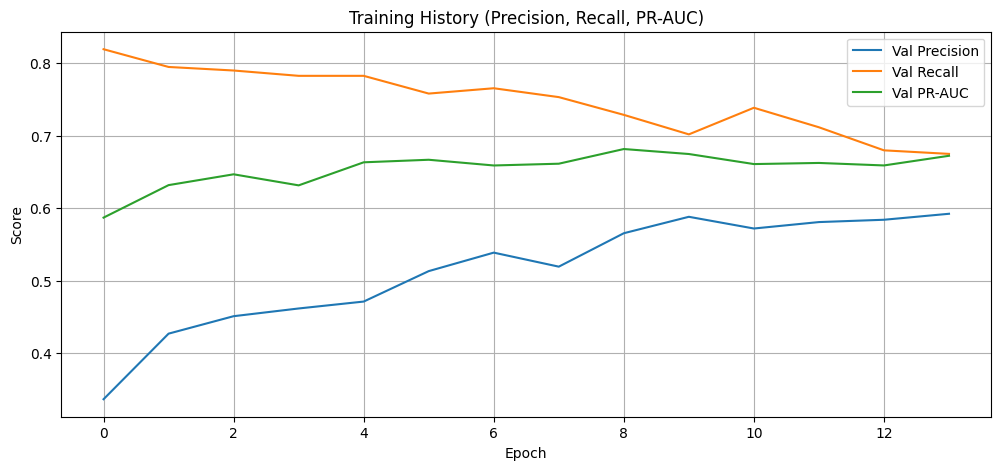

In [83]:
# 10. Plot training history
plt.figure(figsize=(12, 5))

# Precision
# plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')

# Recall
# plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')

# PR-AUC
# plt.plot(history.history['pr_auc'], label='Train PR-AUC')
plt.plot(history.history['val_pr_auc'], label='Val PR-AUC')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Training History (Precision, Recall, PR-AUC)')
plt.legend()
plt.grid(True)
plt.show()

In [84]:
y_probs = model.predict(X_val_scaled)
prec, rec, thresholds = precision_recall_curve(y_val, y_probs)
f2_scores = (5 * prec * rec) / (4 * prec + rec + 1e-9)
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]
print("Best threshold for F2:", best_threshold)
print("Precision:", prec[best_idx], "Recall:", rec[best_idx], "F2:", f2_scores[best_idx])

267/267 [==============================] - 0s 618us/step
Best threshold for F2: 0.24811615
Precision: 0.4932330827067669 Recall: 0.8019559902200489 F2: 0.712733593832675


In [ ]:
y_pred = (model.predict(X_test_scaled) > best_threshold).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
pr_auc = average_precision_score(y_test, y_pred)
print("PR AUC:", pr_auc)

267/267 [==============================] - 0s 792us/step
[[7964  117]
 [ 163  270]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8081
           1       0.70      0.62      0.66       433

    accuracy                           0.97      8514
   macro avg       0.84      0.80      0.82      8514
weighted avg       0.97      0.97      0.97      8514

PR AUC: 0.45418441355387484


In [94]:
for thr in np.arange(best_threshold, 1.0, 0.01):
    y_pred = (y_probs >= thr).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    print(f"Threshold: {thr:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")

Threshold: 0.25, Precision: 0.49, Recall: 0.80
Threshold: 0.26, Precision: 0.50, Recall: 0.79
Threshold: 0.27, Precision: 0.50, Recall: 0.79
Threshold: 0.28, Precision: 0.50, Recall: 0.78
Threshold: 0.29, Precision: 0.51, Recall: 0.78
Threshold: 0.30, Precision: 0.51, Recall: 0.78
Threshold: 0.31, Precision: 0.51, Recall: 0.78
Threshold: 0.32, Precision: 0.51, Recall: 0.78
Threshold: 0.33, Precision: 0.52, Recall: 0.78
Threshold: 0.34, Precision: 0.52, Recall: 0.77
Threshold: 0.35, Precision: 0.52, Recall: 0.77
Threshold: 0.36, Precision: 0.53, Recall: 0.76
Threshold: 0.37, Precision: 0.53, Recall: 0.76
Threshold: 0.38, Precision: 0.53, Recall: 0.76
Threshold: 0.39, Precision: 0.54, Recall: 0.76
Threshold: 0.40, Precision: 0.54, Recall: 0.76
Threshold: 0.41, Precision: 0.54, Recall: 0.75
Threshold: 0.42, Precision: 0.54, Recall: 0.75
Threshold: 0.43, Precision: 0.55, Recall: 0.75
Threshold: 0.44, Precision: 0.55, Recall: 0.74
Threshold: 0.45, Precision: 0.55, Recall: 0.74
Threshold: 0.

In [95]:
base_filename = (
    f"prauc_{pr_auc:.3f}_"
    f"thresh_{best_threshold:.3f}_"
    f"prec_{prec[best_idx]:.3f}_"
    f"rec_{rec[best_idx]:.3f}"
)

model_filename = f"model_{base_filename}.keras"
scaler_filename = f"scaler_{base_filename}.pkl"

print(f"\nSaving model to: {model_filename}")
print(f"Saving scaler to: {scaler_filename}")


Saving model to: model_prauc_0.461_thresh_0.248_prec_0.493_rec_0.802.keras
Saving scaler to: scaler_prauc_0.461_thresh_0.248_prec_0.493_rec_0.802.pkl


In [96]:
model.save(model_filename)

In [97]:
import joblib
joblib.dump(scaler, scaler_filename)

['scaler_prauc_0.461_thresh_0.248_prec_0.493_rec_0.802.pkl']

# 